In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import pickle

from tensorflow import keras
from keras import models, layers
from keras.models import load_model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from qiskit.visualization import plot_histogram 
import seaborn as sns


In [2]:
def NN_model(n_qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'relu', d = 0.0):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal, input_shape = (2 ** n_qubit, )))

    for i in range(n_hidden_layer):
        model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, kernel_initializer= keras.initializers.lecun_normal))
        #model.add(layers.Dropout(d))
            
    model.add(layers.Dense(2 ** n_qubit, activation = 'softmax'))
    
    return model

def loss_function(p_ideal, p_mitigated, n_qubit):
    MSE = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
             x += (abs(p_mitigated[i][j] - p_ideal[i][j]) ** 2)
        x /= 2**n_qubit
        MSE += x
    MSE /= len(p_mitigated)

    KLD = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            if p_ideal[i][j] < 1e-15 or p_mitigated[i][j] < 1e-15:
                x += 0
            else:
                x += p_ideal[i][j] * (math.log(p_ideal[i][j]) - math.log(p_mitigated[i][j]))
        KLD += x
    KLD /= len(p_mitigated)
    
    IF = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            x += math.sqrt(p_ideal[i][j] * p_mitigated[i][j])
        IF += (1 - x**2)
    IF /= len(p_mitigated)

    return MSE, KLD, IF


In [3]:

def get_train_test(x, y, mit, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_miti= mit.sample(n_data, random_state = random_state)
    test_miti = mit.drop(train_miti.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    train_miti.reset_index(drop = True, inplace = True)
    test_miti.reset_index(drop = True, inplace = True)

    return train_x, test_x, train_y, test_y, train_miti, test_miti

def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

def show_plot(topics, unmitigated, LI, NN, type = 0, label = ['unmitigated', 'LI', 'NN']):
    n = 1  # This is our first dataset (out of 2)
    t = 3 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks(value_b_x)
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()


In [4]:
#n_qubits = [5]
#n_data = 300 
#times = [15]
#device_type = "ibm_geneva"
#number = 0

n_qubits = [5]
n_data = 900 
times = [5]
device_type = 'ibmq_toronto'
number = 0

In [5]:
X = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')

# hidden layer : 2, n_node : 3 * (2^5)

In [8]:
n_train_data = 4000
random_state = [99]

trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = random_state[0])


miti = []

model = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 100000,
    decay_rate = 0.96)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
history = model.fit(train_LI_miti, trainY, epochs = 300, batch_size = 1)

miti.append(model.predict(test_LI_miti))
f = device_type + '_' + str(n_qubits[0]) + 'qubits_model.h5'
model.save(f)                

Epoch 1/300
4000/4000 [==============================] - 3s 672us/step - loss: 2.7372 - accuracy: 0.7435
Epoch 2/300
4000/4000 [==============================] - 2s 446us/step - loss: 2.5338 - accuracy: 0.9170
Epoch 3/300
4000/4000 [==============================] - 2s 432us/step - loss: 2.5292 - accuracy: 0.9243
Epoch 4/300
4000/4000 [==============================] - 2s 413us/step - loss: 2.5263 - accuracy: 0.9250
Epoch 5/300
4000/4000 [==============================] - 2s 419us/step - loss: 2.5243 - accuracy: 0.9260
Epoch 6/300
4000/4000 [==============================] - 2s 432us/step - loss: 2.5226 - accuracy: 0.9247
Epoch 7/300
4000/4000 [==============================] - 2s 439us/step - loss: 2.5213 - accuracy: 0.9252
Epoch 8/300
4000/4000 [==============================] - 2s 429us/step - loss: 2.5201 - accuracy: 0.9293
Epoch 9/300
4000/4000 [==============================] - 2s 422us/step - loss: 2.5190 - accuracy: 0.9258
Epoch 10/300
4000/4000 [==============================]

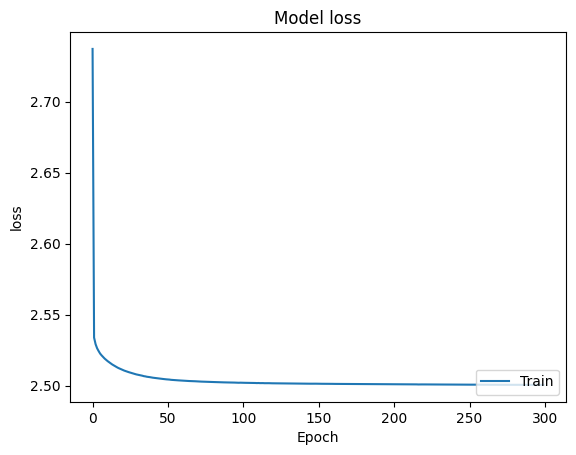

In [9]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [10]:
unmitigated_res = []
LI_res = []
LI_NN_res = []

unmitigated_res.append(loss_function(testY.values, testX.values, n_qubits[0]))
LI_res.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
LI_NN_res.append(loss_function(testY.values, miti[0], n_qubits[0]))

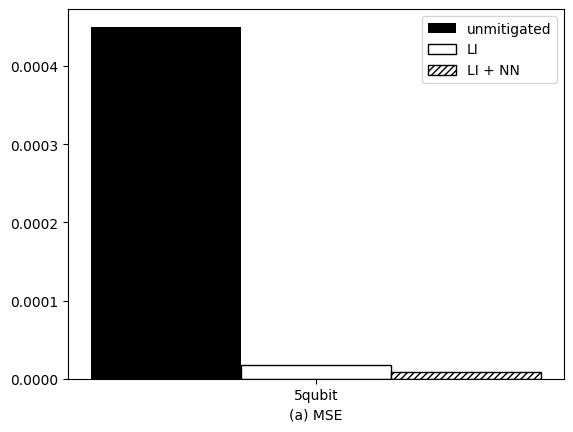

In [11]:
topics = ['5qubit']
label = ['unmitigated', 'LI', 'LI + NN']
show_plot(topics, unmitigated_res, LI_res, LI_NN_res, 0, label)

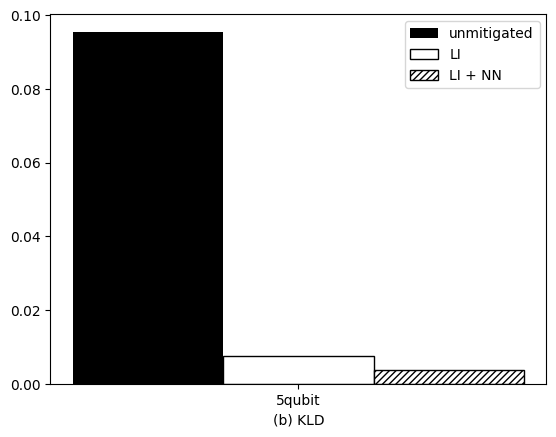

In [12]:
show_plot(topics, unmitigated_res, LI_res, LI_NN_res, 1, label)

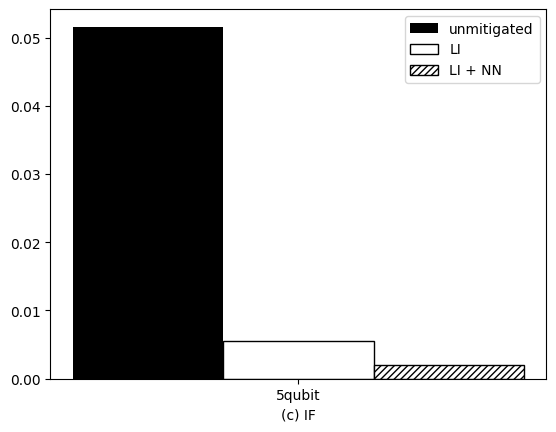

In [13]:
show_plot(topics, unmitigated_res, LI_res, LI_NN_res, 2, label)

# transfer learning

In [14]:
#n_qubits = [5]
#n_data = 300 
#times = [15]
#device_type = "ibm_geneva"
#number = 0

n_qubits = [5]
n_data = 900 
times = [5]
device_type = 'ibmq_toronto'
number = 1

# 아래는 학습한 device
another_device_type = "ibmq_toronto"

In [15]:
X = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')

In [19]:
for i in range(len(n_qubits)):
    f = another_device_type + '_' + str(n_qubits[i]) + 'qubits_model.h5'
    model_t1 = load_model(f)

for layer in model_t1.layers:
    layer.trainable = False

model_t1.layers[3].trainable = True
model_t1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 96)                3168      
                                                                 
 dense_5 (Dense)             (None, 96)                9312      
                                                                 
 dense_6 (Dense)             (None, 96)                9312      
                                                                 
 dense_7 (Dense)             (None, 32)                3104      
                                                                 
Total params: 24,896
Trainable params: 3,104
Non-trainable params: 21,792
_________________________________________________________________


In [20]:
n_train_data = 4000
random_state = [99]

trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = random_state[0])

miti_1 = []

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 100000,
    decay_rate = 0.96)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)
model_t1.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
history_1 = model_t1.fit(trainX, trainY, epochs = 300, batch_size = 1)

miti_1.append(model_t1.predict(testX))           

Epoch 1/300
4000/4000 [==============================] - 2s 371us/step - loss: 2.7137 - accuracy: 0.6317
Epoch 2/300
4000/4000 [==============================] - 1s 358us/step - loss: 2.6591 - accuracy: 0.6833
Epoch 3/300
4000/4000 [==============================] - 1s 372us/step - loss: 2.6396 - accuracy: 0.6942
Epoch 4/300
4000/4000 [==============================] - 1s 372us/step - loss: 2.6279 - accuracy: 0.7020
Epoch 5/300
4000/4000 [==============================] - 1s 367us/step - loss: 2.6202 - accuracy: 0.7010
Epoch 6/300
4000/4000 [==============================] - 1s 370us/step - loss: 2.6149 - accuracy: 0.7125
Epoch 7/300
4000/4000 [==============================] - 1s 368us/step - loss: 2.6107 - accuracy: 0.7155
Epoch 8/300
4000/4000 [==============================] - 1s 367us/step - loss: 2.6076 - accuracy: 0.7190
Epoch 9/300
4000/4000 [==============================] - 1s 371us/step - loss: 2.6053 - accuracy: 0.7178
Epoch 10/300
4000/4000 [==============================]

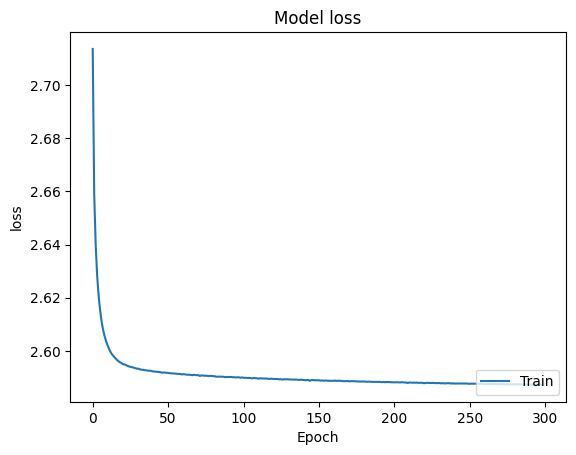

In [21]:
plt.plot(history_1.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [22]:
miti_2 = []
model_t2 = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.0001,
    decay_steps = 100000,
    decay_rate = 0.96)
adam = keras.optimizers.Adam(learning_rate=lr_schedule)

model_t2.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
history_2 = model_t2.fit(trainX, trainY, epochs = 300, batch_size = 1)

miti_2.append(model_t2.predict(testX))

Epoch 1/300
4000/4000 [==============================] - 2s 414us/step - loss: 2.8990 - accuracy: 0.4487
Epoch 2/300
4000/4000 [==============================] - 2s 408us/step - loss: 2.6256 - accuracy: 0.7163
Epoch 3/300
4000/4000 [==============================] - 2s 412us/step - loss: 2.6107 - accuracy: 0.7310
Epoch 4/300
4000/4000 [==============================] - 2s 402us/step - loss: 2.6082 - accuracy: 0.7278
Epoch 5/300
4000/4000 [==============================] - 2s 412us/step - loss: 2.6058 - accuracy: 0.7293
Epoch 6/300
4000/4000 [==============================] - 2s 405us/step - loss: 2.6043 - accuracy: 0.7297
Epoch 7/300
4000/4000 [==============================] - 2s 410us/step - loss: 2.6028 - accuracy: 0.7390
Epoch 8/300
4000/4000 [==============================] - 2s 405us/step - loss: 2.6013 - accuracy: 0.7362
Epoch 9/300
4000/4000 [==============================] - 2s 406us/step - loss: 2.6001 - accuracy: 0.7412
Epoch 10/300
4000/4000 [==============================]

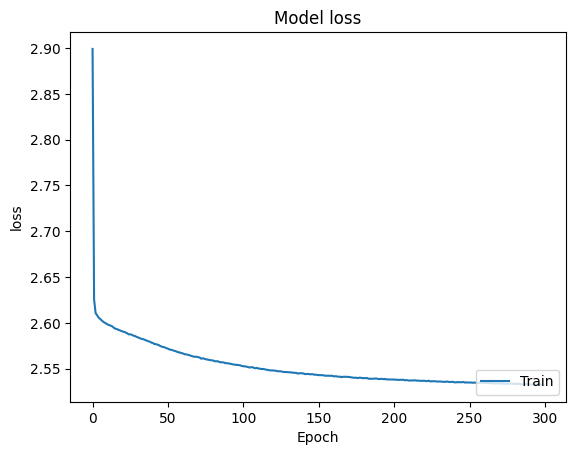

In [23]:
plt.plot(history_2.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [24]:
NN_res2 = []
unmitigated_res2 = []
transfer_res2 = []


unmitigated_res2.append(loss_function(testY.values, testX.values, n_qubits[0]))
NN_res2.append(loss_function(testY.values, miti_2[0], n_qubits[0]))
transfer_res2.append(loss_function(testY.values, miti_1[0], n_qubits[0]))

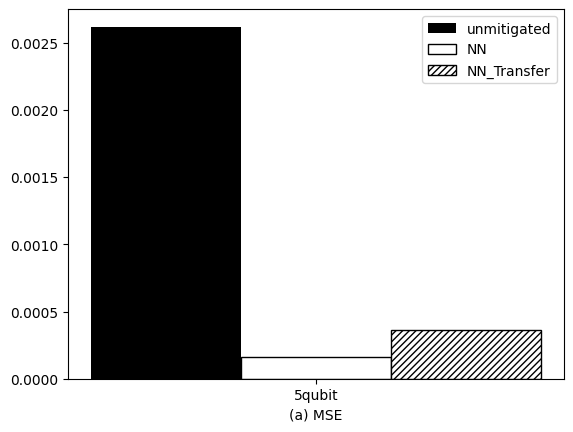

In [25]:
topics = ['5qubit']
label = ['unmitigated', 'NN', 'NN_Transfer']
show_plot(topics, unmitigated_res2, NN_res2, transfer_res2, 0, label)

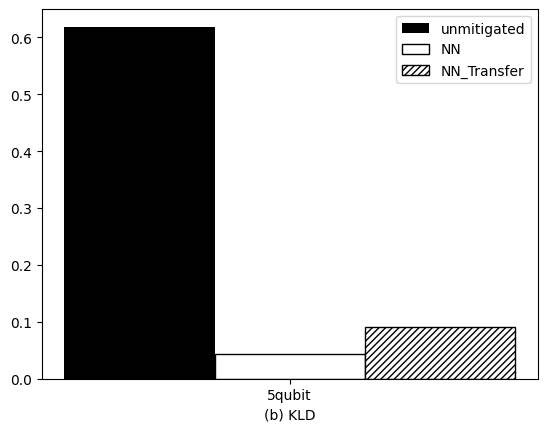

In [26]:
show_plot(topics, unmitigated_res2, NN_res2, transfer_res2, 1, label)

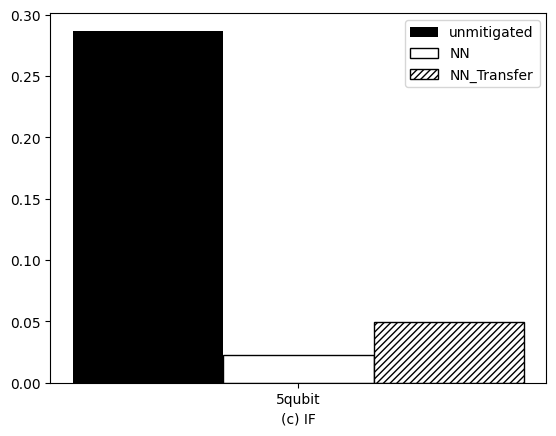

In [27]:
show_plot(topics, unmitigated_res2, NN_res2, transfer_res2, 2, label)